<h1>1. Crawl data</h1>

In [ ]:
from bs4 import BeautifulSoup
import requests
import time
import numpy as np
import copy
import pandas as pd

Đầu tiên chúng ta sẽ tiến hành lấy link của các bộ phim. Chúng ta sẽ tiến hành lấy dữ liệu phim ở trang detail của chúng để đảm bảo có đủ thông tin nhất có thể. Chúng ta vẫn có thể lấy dữ liệu ở trang list nhưng sẽ thiếu các thông tin (description, director, genre...)

In [ ]:
#link of films in reelgood.com
for i in range(0, 5500, 50):
    URL= "https://reelgood.com/movies?offset=" + str(i)
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")

    f = open("/kaggle/working/movies_netflix.txt", "a")
    for link in soup.select('[itemprop=itemListElement] [itemprop=url]'):
        data = link.get('content')
        f.write(data)
        f.write("\n")

Tiến hành tạo ra một object mẫu của film

In [ ]:
filmObj = {
      "Title": None,
      "IMDB_Rating": None,
      "Reelgood_Rating": None,
      "Genres": [],
      "Year": None,
      "Tags": [],
      "Country": None,
      "Source": None,
      "Rated": None,
      "Duration": None,
      "Description": None,
      "Director": None,
      "Employees": [],
}

Tiến hành lấy dữ liệu bằng cách request tới link của các bộ phim trong tập chúng ta vừa lấy được lúc nãy

In [ ]:
with open('/kaggle/input/link-films-crawl/movies_netflix.txt') as f:
    links = [line.rstrip() for line in f]

In [ ]:
arr_film = []
for i in range(0, len(links)):
  link = links[i]
  film = copy.deepcopy(filmObj)

  try:
    with requests.get(link) as page:
      soup = BeautifulSoup(page.content, 'html.parser')
      film['Title'] = soup.find(class_="css-of585f e14injhv7")
      if film['Title'] != None:
        film['Title'] = film['Title'].get_text()

      div_info = soup.find(class_="css-1su90nd ey4ir3j0")

      # GET SCORE
      film['IMDB_Rating'] = div_info.find(class_="css-xmin1q ey4ir3j3").get_text()
      film['Reelgood_Rating'] = div_info.find(class_="css-xmin1q ey4ir3j8")
      if film['Reelgood_Rating'] != None:
        film['Reelgood_Rating'] = film['Reelgood_Rating'].get_text()

      # GET INFO BY TAG A
      list_info = div_info.find_all(class_="css-10wrqt0")
      for info in list_info:
        type_info = info.get("href")
        if('/genre' in type_info):
          film['Genres'].append(info.get_text())
        elif '/year' in type_info:
          film['Year'] = info.get_text()
        elif '/list' in type_info: 
          film['Tags'].append(info.get_text())
        elif '/origin' in type_info:
          film['Country'] = info.get_text()
        elif '/source' in type_info:
          film['Source'] = info.get_text()

      # GET INFO BY TAG META
      film['Rated'] = div_info.find('meta', itemprop='contentRating')
      if film['Rated'] != None:
        film['Rated'] = film['Rated'].get("content", None)
      film['Duration'] = div_info.find('meta', itemprop='duration')
      if film['Duration'] != None: 
        film['Duration'] = film['Duration'].get("content", None)

      # GET DESCRIPTION
      film['Description'] = soup.find('p', itemprop="description").get_text()

      # GET CAST & CREW
      list_employee = soup.find_all('h3', itemprop="name", class_="css-11yr18h egg5eqo2")
      # GET DIRECTOR
      if len(list_employee) > 0:
        film['Director'] = list_employee[0].get_text()
        #GET EMPLOYEE
        for i in range(1, len(list_employee)):
          employee = list_employee[i]
          film['Employees'].append(employee.get_text())

      print(link, " done")
      arr_film.append(film)

  except (NameError, AttributeError) as e:
    print(e)
    continue;
f.close()

tiến hành convert thành dataframe và lưu dưới dạng file csv
<p >
    <span style="text-decoration: underline">Lưu ý</span>: <br />
    Khi request thì có một số link bị hỏng hoặc tiêu đề của film được đánh class sai, do đó sẽ xuất hiện tình trạng không thể lấy dữ liệu và request timeout gây ra vấn đề bị ngắt khi đang lấy. Chúng ta có thể xử lý bằng cách crawl thành từng file nhỏ và ghép chúng lại thành 1 dataframe tổng sau khi đã chạy hết links đã lấy
</p>


In [ ]:
df = pd.DataFrame(arr_film)
df.to_csv('film_reelgood_5k.csv',index=False, encoding="utf-8")

Chúng ta có thể để ý rằng trong đặc trưng Description, thường ở phần cuối nó sẽ có số luợng người đánh giá bộ phim, có thể đặc trưng này sẽ quan trọng nên chúng ta cần tiến hành trích xuất nó ra

In [26]:
df_film = pd.read_csv("film_reelgood_5k.csv", encoding="utf-8")
df_film.loc[0]['Description']

"Follows a reclusive romance novelist who was sure nothing could be worse than getting stuck on a book tour with her cover model, until a kidnapping attempt sweeps them both into a cutthroat jungle adventure, proving life can be so much stranger, and more romantic, than any of her paperback fictions.The Lost City featuring Sandra Bullock and Channing Tatum is streaming on Paramount+, streaming on Epix, available for purchase on iTunes, and 2 others. It's an action & adventure and romance movie with an average IMDb audience rating of 6.2 (48,599 votes)."

In [ ]:
arr_votes = []

# extract user votes
for i in df_film['Description']:
    sub_str = i[-50:]
    startIndex = sub_str.find("(")
    endIndex = sub_str.find(")")
    if('votes' in sub_str[startIndex: endIndex]):
        arr_votes.append(sub_str[startIndex + 1: endIndex])
    else: arr_votes.append(np.NaN)

# concat into df and save as file csv
arr_votes = np.array(arr_votes)
df_votes = pd.DataFrame(arr_votes, columns = ['User_Votes'])
result = pd.concat([df_film, df_votes], axis=1)
result.info()
result.head(2)
result.to_csv("film_full.csv", encoding="utf-8")

<h1>2. EDA</h1>

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./film_full.csv", encoding="utf-8")
df = df.drop(["Reelgood_Rating"], axis=1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   4455 non-null   int64  
 1   Title        4455 non-null   object 
 2   IMDB_Rating  4455 non-null   float64
 3   Genres       4455 non-null   object 
 4   Year         4455 non-null   int64  
 5   Tags         4455 non-null   object 
 6   Country      2825 non-null   object 
 7   Source       2803 non-null   object 
 8   Rated        1856 non-null   object 
 9   Duration     4324 non-null   object 
 10  Description  4455 non-null   object 
 11  Director     3548 non-null   object 
 12  Employees    4455 non-null   object 
 13  User_Votes   4396 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 487.4+ KB


In [4]:
df.head(3)

,Unnamed: 0,Title,IMDB_Rating,Genres,Year,Tags,Country,Source,Rated,Duration,Description,Director,Employees,User_Votes
0,0,The Lost City,6.2,"['Romance', 'Action & Adventure']",2022,[],America,Epix,13+ (PG-13),PT1H52M,Follows a reclusive romance novelist who was s...,Aaron Nee,"['Adam Nee', 'Sandra Bullock', 'Channing Tatum...","48,599 votes"
1,1,Chip 'n Dale: Rescue Rangers,7.2,"['Action & Adventure', 'Animation']",2022,[],NaN,Disney+,7+ (PG),PT1H39M,Thirty years after their popular television sh...,NaN,[],"13,451 votes"
2,2,Uncharted,6.4,"['Drama', 'Action & Adventure']",2022,['Video Games'],America,NaN,13+ (PG-13),PT1H56M,"A young street-smart, Nathan Drake and his wis...",Ruben Fleischer,"['Tom Holland', 'Mark Wahlberg', 'Antonio Band...","118,363 votes"


Tiến hành xử lý dữ liệu đơn giản và encoding cột Genre để phục vụ cho bước EDA sau này

In [5]:
mlb = MultiLabelBinarizer()
# Change format data
df["Genres"] = df["Genres"].apply(lambda x: x.replace("'", "") if "'" in x else x)
df["Tags"] = df["Tags"].apply(lambda x: x.replace("'", "") if "'" in x else x)
df["Employees"] = df["Employees"].apply(lambda x: x.replace("'", "") if "'" in x else x)

df["Genres"] = df["Genres"].apply(lambda x: x.replace("[", "") if "[" in x else x)
df["Tags"] = df["Tags"].apply(lambda x: x.replace("[", "") if "[" in x else x)
df["Employees"] = df["Employees"].apply(lambda x: x.replace("[", "") if "[" in x else x)

df["Genres"] = df["Genres"].apply(lambda x: x.replace("]", "") if "]" in x else x)
df["Tags"] = df["Tags"].apply(lambda x: x.replace("]", "") if "]" in x else x)
df["Employees"] = df["Employees"].apply(lambda x: x.replace("]", "") if "]" in x else x)

df["Genres"] = df["Genres"].apply(lambda x: x + 'empty' if not x else x)
df["Tags"] = df["Tags"].apply(lambda x: x + 'empty' if not x else x)
df["Employees"] = df["Employees"].apply(lambda x: x + 'empty' if not x else x)

# explode genres
df = df.join(
            pd.DataFrame(
                mlb.fit_transform(df['Genres'].str.split(', ')),
                index=df.index,
                columns="Genre_" + mlb.classes_))

# # explode tags 
# df = df.join(
#             pd.DataFrame(
#                 mlb.fit_transform(df.pop('Tags').str.split(', ')),
#                 index=df.index,
#                 columns="Tag_" + mlb.classes_))

# convert user votes to number
df["User_Votes"] = df["User_Votes"].astype(str)
df['User_Votes'] = df['User_Votes'].apply(lambda x: int(x.replace(",", "").split(" ")[0].strip()) if 'nan' not in x else 0)

# convert duration to number
df["Duration"] = df["Duration"].astype(str)
def convert_to_minutes(str_duration): 
    if str_duration != 'nan':
        str_duration = str_duration[2:].replace("M", "")
        if "H" in str_duration:
            arr_time = str_duration.split("H")
            return int(arr_time[0]) * 60 + int(arr_time[1])
        else:
            return int(str_duration)
    else: return 0
df['Duration'] = df['Duration'].apply(lambda x: convert_to_minutes(x))


In [6]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                4455 non-null   int64  
 1   Title                     4455 non-null   object 
 2   IMDB_Rating               4455 non-null   float64
 3   Genres                    4455 non-null   object 
 4   Year                      4455 non-null   int64  
 5   Tags                      4455 non-null   object 
 6   Country                   2825 non-null   object 
 7   Source                    2803 non-null   object 
 8   Rated                     1856 non-null   object 
 9   Duration                  4455 non-null   int64  
 10  Description               4455 non-null   object 
 11  Director                  3548 non-null   object 
 12  Employees                 4455 non-null   object 
 13  User_Votes                4455 non-null   int64  
 14  Genre_Ac

,Unnamed: 0,Title,IMDB_Rating,Genres,Year,Tags,Country,Source,Rated,Duration,...,Genre_Horror,Genre_LGBTQ,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Science-Fiction,Genre_Sport,Genre_Stand-up & Talk,Genre_Thriller,Genre_empty
0,0,The Lost City,6.2,"Romance, Action & Adventure",2022,empty,America,Epix,13+ (PG-13),112,...,0,0,0,0,1,0,0,0,0,0
1,1,Chip 'n Dale: Rescue Rangers,7.2,"Action & Adventure, Animation",2022,empty,NaN,Disney+,7+ (PG),99,...,0,0,0,0,0,0,0,0,0,0
2,2,Uncharted,6.4,"Drama, Action & Adventure",2022,Video Games,America,NaN,13+ (PG-13),116,...,0,0,0,0,0,0,0,0,0,0
3,3,Spider-Man: No Way Home,8.3,"Comedy, Drama",2021,"Teen, Superhero, Supernatural",America,NaN,13+ (PG-13),148,...,0,0,0,0,0,0,0,0,0,0
4,4,Top Gun,6.9,"Romance, Action & Adventure",1986,"Military, Feel-good",America,Paramount+,13+ (PG-13),110,...,0,0,0,0,1,0,0,0,0,0


<h2>Top 20 phim được đánh giá cao nhất</h2>

In [7]:
top20_films = df.sort_values(by='IMDB_Rating', ascending=False)[:20]

Text(0.5, 0.98, 'High rating film')

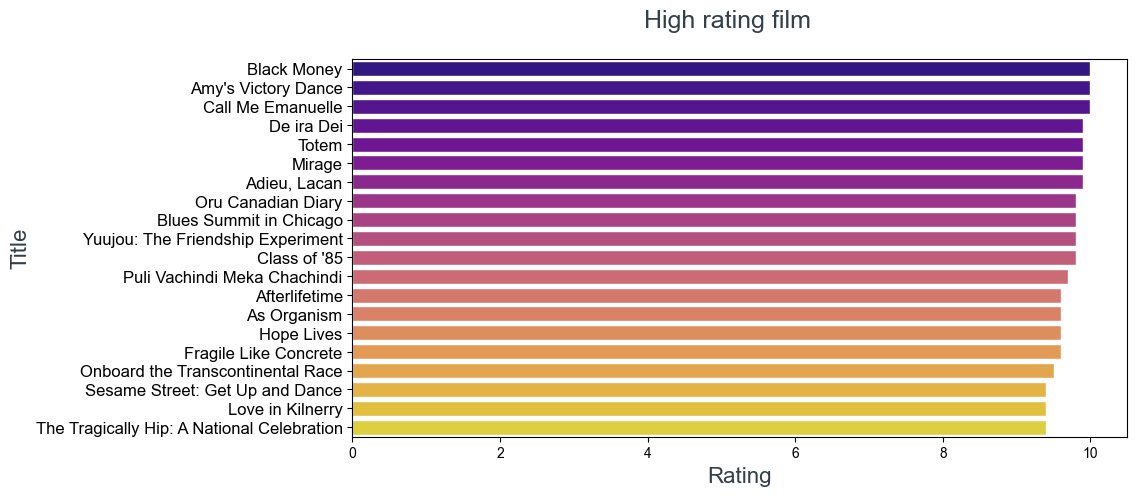

In [8]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
plt.yticks(size=12)
sns.set(style="darkgrid")
# plot the data
sns.barplot(data=top20_films, x='IMDB_Rating', y='Title', palette='plasma')
# set x and y-axis labels and title
ax.set_xlabel('Rating', fontsize=16, color = '#333F4B')
ax.set_ylabel('Title', fontsize=16, color = '#333F4B')
fig.suptitle('High rating film',fontsize=18, color = '#333F4B')

Ta có thể thấy được top 20 film thì điểm rating cách không quá lớn (đa số chạy từ 9-10). Do đó khi xử lý dữ liệu thì ta có thể không cần phải xử lý ngoại lệ đối với cột này

<h2>Phần lớn các bộ phim được đánh giá như thế nào?</h2>

d:\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


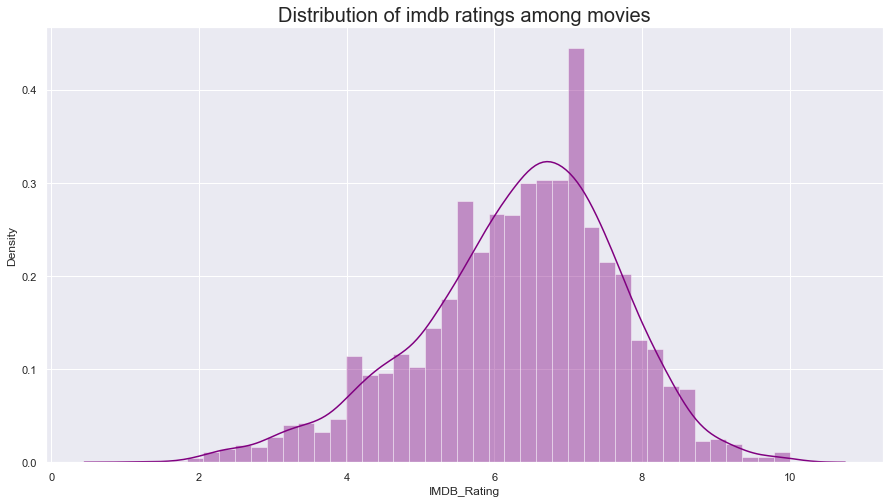

In [9]:
fig, ax = plt.subplots(figsize = (15,8))
sns.distplot(df['IMDB_Rating'], color="purple");
plt.title("Distribution of imdb ratings among movies", size = 20);

Điểm rating của các film có phân bố gần với phân bố, điểm rating mà các film nhận được nhiều nhất là khoảng 7

<h2>Tần suất phát hành phim qua các năm</h2>

In [10]:
years = []
df['Year'].apply(lambda x: years.append(x))
unique, counts = np.unique(years, return_counts=True)
year_dataframe = pd.DataFrame({"unique":unique,"counts":counts})
year_dataframe = year_dataframe.sort_values(['counts'],ascending=[False])

Text(0.5, 0.98, 'Movie release frequency by years')

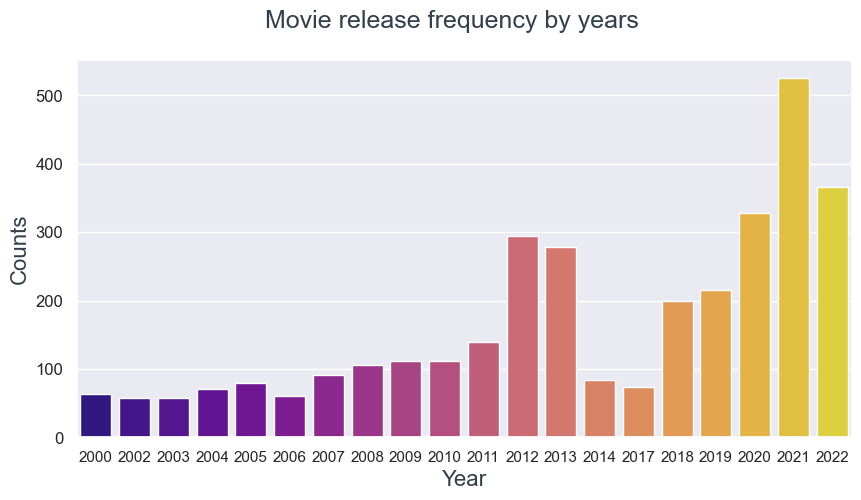

In [11]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
plt.yticks(size=12)
sns.set(style="darkgrid")
# plot the data
sns.barplot(data=year_dataframe[:20], x='unique', y='counts', palette='plasma')
# set x and y-axis labels and title
ax.set_xlabel('Year', fontsize=16, color = '#333F4B')
ax.set_ylabel('Counts', fontsize=16, color = '#333F4B')
fig.suptitle('Movie release frequency by years',fontsize=18, color = '#333F4B')


<ul>
    <li>Tần suất ra phim không tăng tuyến tính theo từng năm mà có sự biến động mạnh (giảm) vào năm 2014-2017</li>
    <li>Năm 2021 là năm có tần suất ra phim cao nhất</li>
</ul>

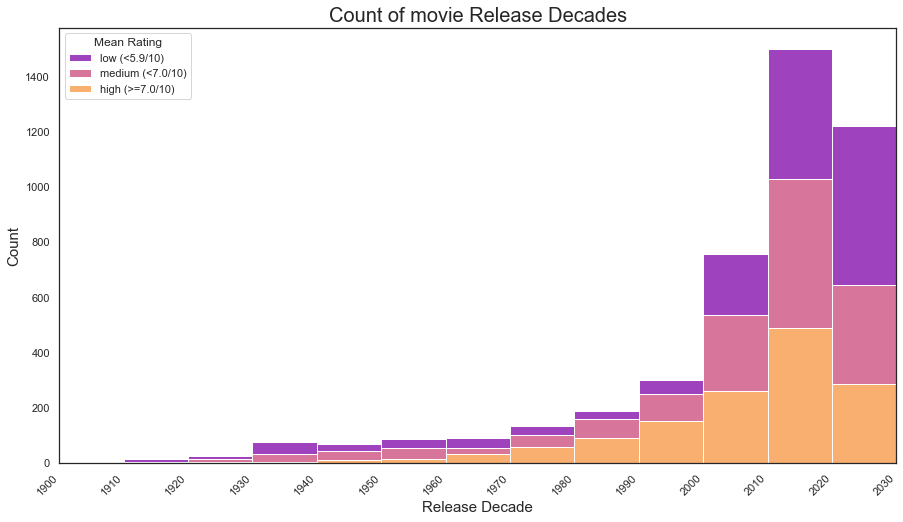

In [23]:
# create three main categories of mean rating
df['mean_rating_qcut'], qcut_mean_ratings = pd.qcut(x=df['IMDB_Rating'], q=3, retbins=True)
mean_rating_labels = ['low (<' + str(qcut_mean_ratings[1]) + '/10)',
                   'medium (<' + str(qcut_mean_ratings[2]) + '/10)',
                   'high (>=' + str(qcut_mean_ratings[2]) + '/10)']
df['mean_rating_qcut'] = pd.qcut(x=df['IMDB_Rating'], q=3, labels=mean_rating_labels)
# find decade of dataset
df['Decade'] = (df['Year']//10)*10
n_bins = int(((df['Decade'].max()-df['Decade'].min())/10)+1)

# Count of movies release year
sns.set(style='white')

plt.figure(figsize=(15, 8))
plt.title('Count of movie Release Decades', size=20)
ax = sns.histplot(data=df.sort_values(by='mean_rating_qcut'), x='Decade', hue='mean_rating_qcut', multiple='stack', bins=n_bins, binrange=(df['Decade'].min(), df['Decade'].max()+10), palette='plasma')
ax.margins(x=0)
ax.legend_.set_title('Mean Rating') 
plt.xlabel('Release Decade', size=15)
plt.ylabel('Count', size=15)
plt.xticks(np.arange(df['Decade'].min(), df['Decade'].max()+20, step=10), rotation=45, ha='right')
plt.show()

thập kỉ 2010 có thể được xem là thập kỉ có chất lượng phim tốt nhất và số lượng phim nhiều nhất

<h2>Most popular genres</h2>

In [13]:
genres = []
df['Genres'].apply(lambda x: genres.append(str(x).split(", ")))
all_genres = np.array([genre for sub_list in genres for genre in sub_list])
unique, counts = np.unique(all_genres, return_counts=True)
genre_dataframe = pd.DataFrame({"unique":unique,"counts":counts})
genre_dataframe = genre_dataframe.sort_values(['counts'],ascending=[False])

Text(0.5, 0.98, 'Most popular genres')

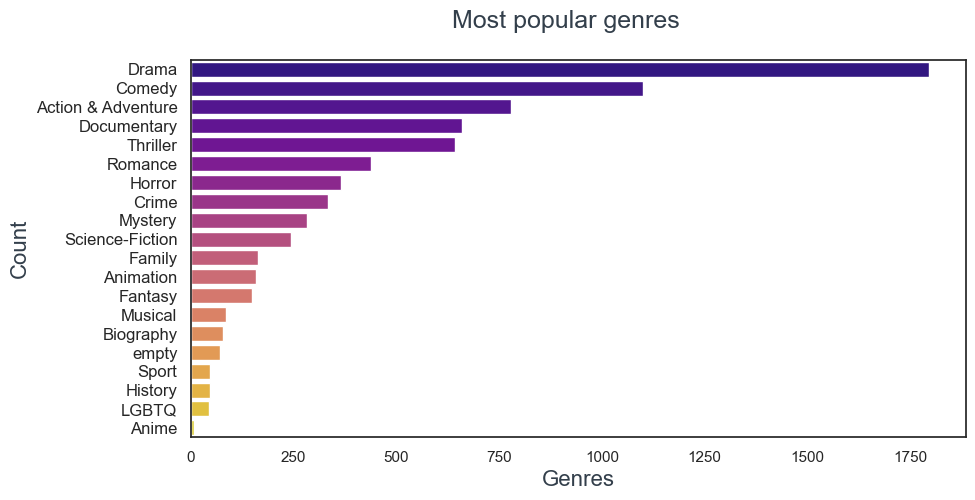

In [14]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
plt.yticks(size=12)
sns.set(style="darkgrid")
# plot the data
sns.barplot(data=genre_dataframe[:20], x='counts', y='unique', palette='plasma')
# set x and y-axis labels and title
ax.set_xlabel('Genres', fontsize=16, color = '#333F4B')
ax.set_ylabel('Count', fontsize=16, color = '#333F4B')
fig.suptitle('Most popular genres',fontsize=18, color = '#333F4B')

<img src="https://scontent.fdad3-4.fna.fbcdn.net/v/t1.6435-9/40506420_1428681267266723_4159529269006958592_n.jpg?_nc_cat=101&ccb=1-7&_nc_sid=e3f864&_nc_ohc=1iia7R9HhekAX_CnV1P&_nc_ht=scontent.fdad3-4.fna&oh=00_AT9a2-BQ5lT_uneLWrffcEpZXN8HzleUj03ZMsaGOzx0BQ&oe=62BB926C" alt="imgage" style="display:block; width: 50%; margin: 0 auto" />
<p>Có thể các nhà làm phim muốn đánh vào thị hiếu số đông (thể loại này dễ gây thích thú, tò mò, tạo hiệu ứng số đông), giúp tăng doanh số của phim</p>

<h2>Mean rating of each genre</h2>

In [15]:
genre_df = df.loc[:, df.columns.str.startswith('Genre')].join(df['IMDB_Rating'])
genre_df = genre_df.drop(['Genre_empty'], axis=1)

# create dict
dict_genre = {}
for column in genre_df.columns[1:-1]:
    dict_genre[column] = np.array([])

# add imdb rating each genre into dict 
def add_rating(x):
    for i in x[1:-1].keys():
        if x[i] == 1:
            dict_genre[i] = np.append(dict_genre[i], x[-1])
genre_df.apply(lambda x: add_rating(x), axis=1)

# calc mean
for i in dict_genre:
    dict_genre[i] = np.mean(dict_genre[i])

dict_df = pd.DataFrame.from_dict(dict_genre, orient='index')
dict_df["Genre"] = dict_df.index

Text(0.5, 0.98, 'Mean Rating of each genre')

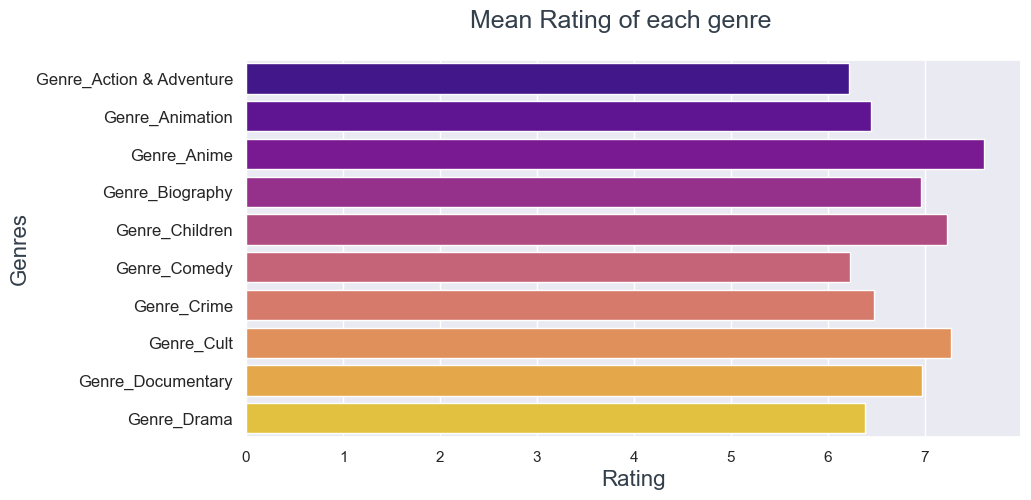

In [16]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
plt.yticks(size=12)
sns.set(style="darkgrid")
# plot the data
sns.barplot(data=dict_df[:10], x=0, y="Genre", palette='plasma')
# set x and y-axis labels and title
ax.set_xlabel('Rating', fontsize=16, color = '#333F4B')
ax.set_ylabel('Genres', fontsize=16, color = '#333F4B')
fig.suptitle('Mean Rating of each genre',fontsize=18, color = '#333F4B')

<p>Các thể loại dành cho độ tuổi thiếu nhi thì có độ rating cao hơn các thể loại khác. Thể loại phim văn hoá, tôn giáo và phim tài liệu cũng được cộng đồng đón nhận mạnh mẽ</p>

<h2>Top 10 movie release countries</h2>

In [17]:
languages = []
df['Country'].apply(lambda x: languages.append(x) if str(x).strip() != 'nan' else None)
unique_language, counts_language = np.unique(languages, return_counts=True)
language_dataframe = pd.DataFrame({"unique":unique_language,"counts":counts_language})
language_dataframe = language_dataframe.sort_values(['counts'],ascending=[False])

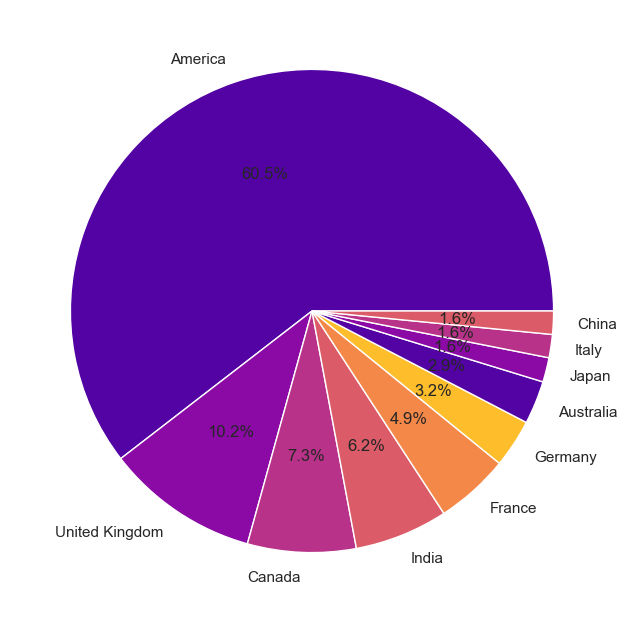

In [18]:
data = language_dataframe['counts'][0:10]
labels = language_dataframe['unique'][0:10]

#define Seaborn color palette to use
colors = sns.color_palette('plasma')

#create pie chart
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
plt.pie(data, labels = labels, colors = colors, autopct="%.1f%%");

<p>Qua đây ta có thể thấy được nền công nghiệp điện ảnh ở Mỹ phát triển rất mạnh mẽ. Và rất may có phimmoi.net, nếu không muốn coi được nhiều phim bắt buộc chúng ta phải giỏi tiếng anh</p>
<p>Và đất nước chuyên sản xuất những bộ phim phi vật lý là Ấn độ lại đứng vị trí thứ 5 trong những quốc gia sản xuất nhiều phim nhất</p>
<img src="https://media3.giphy.com/media/3oEhmI1Y4GlCPczg1W/giphy.gif?cid=ecf05e476ac1hr00h22jjqjyaf2qxdro1fr34kicsk1d1k5h&rid=giphy.gif&ct=g" style="display:block; width: 50%; margin: 0 auto" alt="gif" />

<h2>How long are the movies?</h2>

d:\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


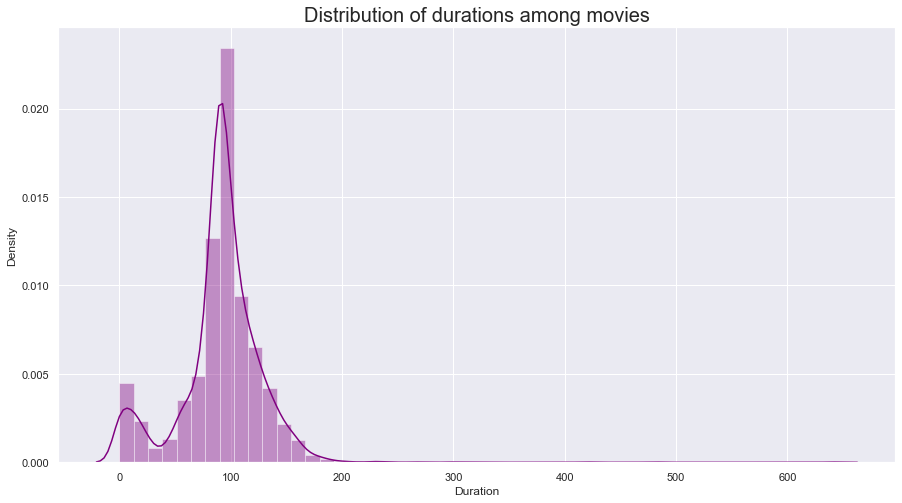

In [19]:
fig, ax = plt.subplots(figsize = (15,8))
sns.distplot(df['Duration'], color="purple");
plt.title("Distribution of durations among movies", size = 20);

<p>Đa số các bộ phim có độ dài từ 1 tiếng rưỡi.</p>

<h2>Correlation of IMDB rating and other factors</h2>

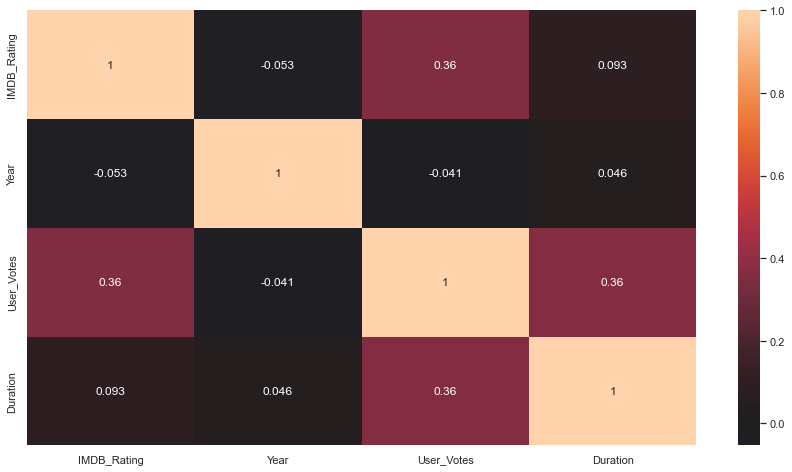

In [21]:
fig, ax = plt.subplots(figsize = (15,8))
sns.heatmap(df[['IMDB_Rating', 'Year', 'User_Votes', 'Duration']].corr(),
            center=0, annot=True
           );

Dataset có độ tương quan khá thấp, User votes có độ tương quan cao nhất với IMDB rating (0.36)

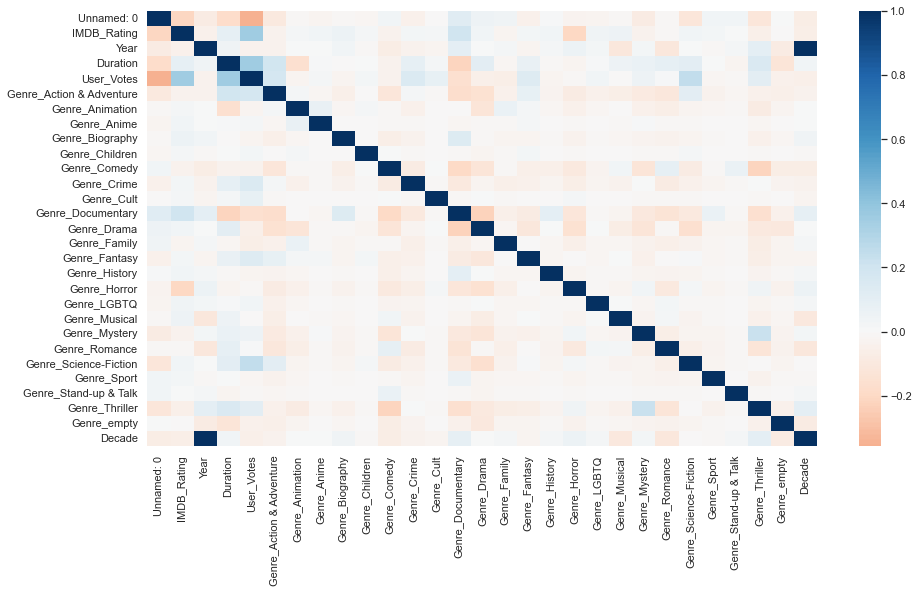

In [25]:
fig, ax = plt.subplots(figsize = (15,8))
sns.heatmap(df.corr(), 
            center = 0, 
           cmap = 'RdBu');

<ul>
    <li>Ta có thể thấy được trong bộ dataset này thì đặc trưng Rating có độ tương quan thấp đối với các đặc trưng khác.</li>
    <li>User votes và thể loại phim tài liệu thì sự tương quan với rating cao hơn các đặc trưng khác. Do đó ta có thể sử dụng 2 đặc trưng này để dự đoán điểm rating của một bộ phim</li>
<ul>